In [2]:
!python print("Hello, World!")

SyntaxError: invalid syntax (2783294118.py, line 1)

In [3]:
import os
from math import log10
import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from loss import GeneratorLoss
from model import Generator, Discriminator

# Default values
CROP_SIZE = 88
UPSCALE_FACTOR = 4
NUM_EPOCHS = 100

# Paths to the datasets
train_set = TrainDatasetFromFolder('/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder('/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL_val', upscale_factor=UPSCALE_FACTOR)

# DataLoaders
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

# Initialize model and loss
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()
generator_criterion = GeneratorLoss()

# Check if GPU is available
if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

# Optimizers
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

# Results dictionary
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': [], 'loss_ratio': [], 'learning_rate': [], 'fid': []}

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = target
        if torch.cuda.is_available():
            real_img = real_img.float().cuda()
        z = data
        if torch.cuda.is_available():
            z = z.float().cuda()
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        optimizerG.step()

        real_out = netD(real_img).mean()
        fake_out = netD(fake_img.detach()).mean()
        d_loss = 1 - real_out + fake_out

        optimizerD.zero_grad()
        d_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerD.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    
    # Validation
    netG.eval()
    out_path = 'training_results/SRF_'+ str(UPSCALE_FACTOR) + 'X_LL' + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        index = 1
        saved_images = 0  
        max_saved_images = 50  

        for val_lr, val_hr_restore, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size

            lr = val_lr.cuda() if torch.cuda.is_available() else val_lr
            hr = val_hr.cuda() if torch.cuda.is_available() else val_hr
            sr = netG(lr)

            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size

            batch_ssim = pytorch_ssim.ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size

            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']

            val_bar.set_description(desc=f'[Converting LR to SR] PSNR: {valing_results["psnr"]:.4f} dB SSIM: {valing_results["ssim"]:.4f}')

            for i in range(batch_size):
                if saved_images >= max_saved_images:  
                    break

                sr_image = display_transform()(sr[i].cpu())
                hr_image = display_transform()(hr[i].cpu())
                lr_image = display_transform()(val_hr_restore[i])

                grid = utils.make_grid([lr_image, hr_image, sr_image], nrow=3, padding=5)
                utils.save_image(grid, os.path.join(out_path, f'epoch_{epoch}_index_{index}.png'), padding=5)

                index += 1
                saved_images += 1  

                if saved_images >= max_saved_images:  
                    break

    # Save models
    torch.save(netG.state_dict(), 'epochs/LL/netG_LL_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    torch.save(netD.state_dict(), 'epochs/LL/netD_LL_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))

    # Collect results
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])
    results['loss_ratio'].append((running_results['g_loss'] / running_results['batch_sizes']) / (running_results['d_loss'] / running_results['batch_sizes']))
    results['learning_rate'].append(optimizerG.param_groups[0]['lr'])

    # Save statistics every 10 epochs
    if epoch % 10 == 0:
        out_path = 'statistics/'
        os.makedirs(out_path, exist_ok=True)
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim'],
                  'Loss_Ratio': results['loss_ratio'], 'Learning_Rate': results['learning_rate']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + 'x_LL' + '_train_results.csv', index_label='Epoch')


/home/dst/anaconda3/envs/srgan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dst/anaconda3/envs/srgan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/113 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 9, 9], expected input[64, 1, 22, 22] to have 3 channels, but got 1 channels instead

In [5]:
import cv2 
import numpy as np
import os

In [19]:
img = cv2.imread('/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL_val/image_3445_rotate_LL.png')

In [ ]:
Pat

In [13]:
img.shape


(256, 256, 3)

In [20]:
from PIL import Image
path = '/home/dst/Desktop/GAN/SRGAN/data/wavlet/LL_val/image_3445_rotate_LL.png'
imgr = Image.open(path).convert("RGB")  # Convert grayscale to RGB


In [17]:
cv2_disp('image', img)
cv2.waitKey(0)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


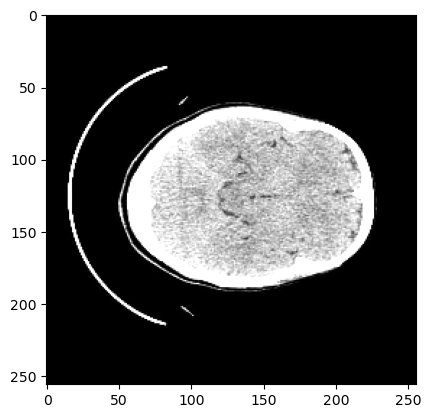

In [25]:
import matplotlib.pyplot as plt
plt.imshow(imgr)